<a href="https://colab.research.google.com/github/yj-shin/yj-shin.github.io/blob/master/LSTM_DNN_TOTAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Load relevant libraries
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
import tensorflow.keras as keras

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import argparse
import locale
import os

In [41]:
filepath = '/content/drive/MyDrive/test/'
filename = 'MiningProcess_Flotation_Plant_Database.csv'
cols_renamed = [
    'date',          # Timestamp of measurements, formatted YYYY-MM-DD HH:MM:SS
    'feed_iron',     # %Iron (valuables) in the ore being fed into the flotation cell
    'feed_silica',   # %Silica (gangue) in the ore being fed into the cell
    'starch_flow',   # Amount of starch (reagent) added into the cell, measured in m^3/h
    'amina_flow',    # Amount of amina (reagent) added into the cell, measured in m^3/h
    'pulp_flow',     # Amount of ore pulp fed into the cell, measured in tonnes/hour
    'pulp_ph',       # Acidity/alkalinity of ore pulp on a scale of 0-14
    'pulp_density',  # Amount of ore in the pulp, between 1-3 kg/cm^3
    'air_col1',      # Volume of air injected into the cell, measured in Nm3/h
    'air_col2',
    'air_col3',
    'air_col4',
    'air_col5',
    'air_col6',
    'air_col7',
    'level_col1',    # Froth height in the cell, measured in mm
    'level_col2',
    'level_col3',
    'level_col4',
    'level_col5',
    'level_col6',
    'level_col7',
    'conc_iron',     # Lab measurement: %Iron in the end of flotation process
    'conc_silica']   # Lab measurement: %Silica in the end of flotation process
df = pd.read_csv(
    filepath+filename,
    header=0,
    names=cols_renamed,
    parse_dates=['date'],
    infer_datetime_format=True,
    decimal=',')
df.head()

,date,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          737453 non-null  datetime64[ns]
 1   feed_iron     737453 non-null  float64       
 2   feed_silica   737453 non-null  float64       
 3   starch_flow   737453 non-null  float64       
 4   amina_flow    737453 non-null  float64       
 5   pulp_flow     737453 non-null  float64       
 6   pulp_ph       737453 non-null  float64       
 7   pulp_density  737453 non-null  float64       
 8   air_col1      737453 non-null  float64       
 9   air_col2      737453 non-null  float64       
 10  air_col3      737453 non-null  float64       
 11  air_col4      737453 non-null  float64       
 12  air_col5      737453 non-null  float64       
 13  air_col6      737453 non-null  float64       
 14  air_col7      737453 non-null  float64       
 15  level_col1    737

In [43]:
df.describe()

,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380,280.151856,277.159965,281.082397,299.447794,299.917814,292.071485,290.754856,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231,65.050068,2.326763
std,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249,29.621288,30.149357,28.558268,2.572538,3.636579,30.217804,28.670105,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491,1.118645,1.125554
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,292.195000,286.295000,189.928000,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,298.262566,298.068000,262.541000,256.302000,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,299.805000,299.887120,299.477000,299.011000,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000,65.210000,2.000000
75%,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,300.638000,301.791137,303.061000,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,305.871000,310.270000,370.910000,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


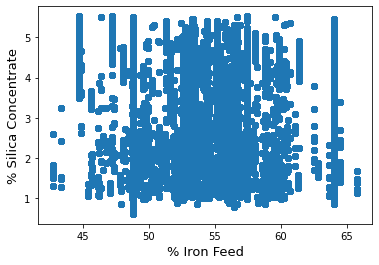

In [45]:
fig, ax = plt.subplots()
ax.scatter(x = df['feed_iron'], y = df['conc_silica'])
plt.ylabel('% Silica Concentrate', fontsize=13)
plt.xlabel('% Iron Feed', fontsize=13)
plt.show()

In [50]:
# time = df.loc(axis=0)[:, df.columns != 'feed_iron', 'feed_silica', 'conc_silica']
# time = pd.DataFrame([df, df.columns != 'feed_iron', 'feed_silica', 'conc_silica'])

from sklearn.model_selection import KFold, cross_val_score, train_test_split

X = df[df.columns.difference(['feed_iron', 'feed_silica', 'conc_silica'])]
notime = df[['feed_iron', 'feed_silica']]
# target = df['conc_silica']


# X = df.iloc[df.columns != 'feed_iron', 'feed_silica', 'conc_silica']
y = df['conc_silica']



    # 'date',          # Timestamp of measurements, formatted YYYY-MM-DD HH:MM:SS
    # 'feed_iron',     # %Iron (valuables) in the ore being fed into the flotation cell
    # 'feed_silica',   # %Silica (gangue) in the ore being fed into the cell
    # 'starch_flow',   # Amount of starch (reagent) added into the cell, measured in m^3/h
    # 'amina_flow',    # Amount of amina (reagent) added into the cell, measured in m^3/h
    # 'pulp_flow',     # Amount of ore pulp fed into the cell, measured in tonnes/hour
    # 'pulp_ph',       # Acidity/alkalinity of ore pulp on a scale of 0-14
    # 'pulp_density',  # Amount of ore in the pulp, between 1-3 kg/cm^3
    # 'air_col1',      # Volume of air injected into the cell, measured in Nm3/h
    # 'air_col2',
    # 'air_col3',
    # 'air_col4',
    # 'air_col5',
    # 'air_col6',
    # 'air_col7',
    # 'level_col1',    # Froth height in the cell, measured in mm
    # 'level_col2',
    # 'level_col3',
    # 'level_col4',
    # 'level_col5',
    # 'level_col6',
    # 'level_col7',
    # 'conc_iron',     # Lab measurement: %Iron in the end of flotation process
    # 'conc_silica']   # Lab measurement: %Silica in the end of flotation process




train_X_t, train_y_t, valid_X_t, valid_y_t, test_X_t, test_y_t = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=target, random_state=42)
train_X_nt, train_y_nt, valid_X_nt, valid_y_nt, test_X_nt, test_y_nt = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=target, random_state=42)

ValueError: ignored

In [ ]:
notime.info()

In [ ]:
train_X_t, train_y_t, valid_X_t, valid_y_t, test_X_t, test_y_t = train_test_split(time, target, test_size=0.3, shuffle=True, stratify=target, random_state=42)
train_X_nt, train_y_nt, valid_X_nt, valid_y_nt, test_X_nt, test_y_nt = train_test_split(time, target, test_size=0.3, shuffle=True, stratify=target, random_state=42)